In [1]:
import os
import glob
import time

from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook, tnrange
import numpy as np

import seaborn as sns
sns.set(style="ticks", color_codes=True)

%matplotlib inline 

In [2]:
start = time.time()
df = pd.read_parquet('/scratch/t.cri.awoodard/cgp_pindel_filtered_shuffled.parquet')
print('read df in {:.1f} seconds'.format(time.time() - start))

read df in 86.8 seconds


In [3]:
df = df[:5000000]

In [4]:
race_data = pd.read_csv('/home/t.cri.awoodard/indel-filtering/race.csv')

In [19]:
df['race'] = 'nigerian'
for row in race_data.iterrows():
    sample, race = row[1]
    df.loc[df.SAMPLE == sample, 'race'] = 'TCGA ' + race

In [20]:
df['filter'] = 'pass'
df.loc[df.FILTER == 'pseudo_pon', 'filter'] = 'only fails pseudo PON'
df.loc[(df.FILTER != 'pseudo_pon') & (df.FILTER != 'PASS'), 'filter'] = 'fail'

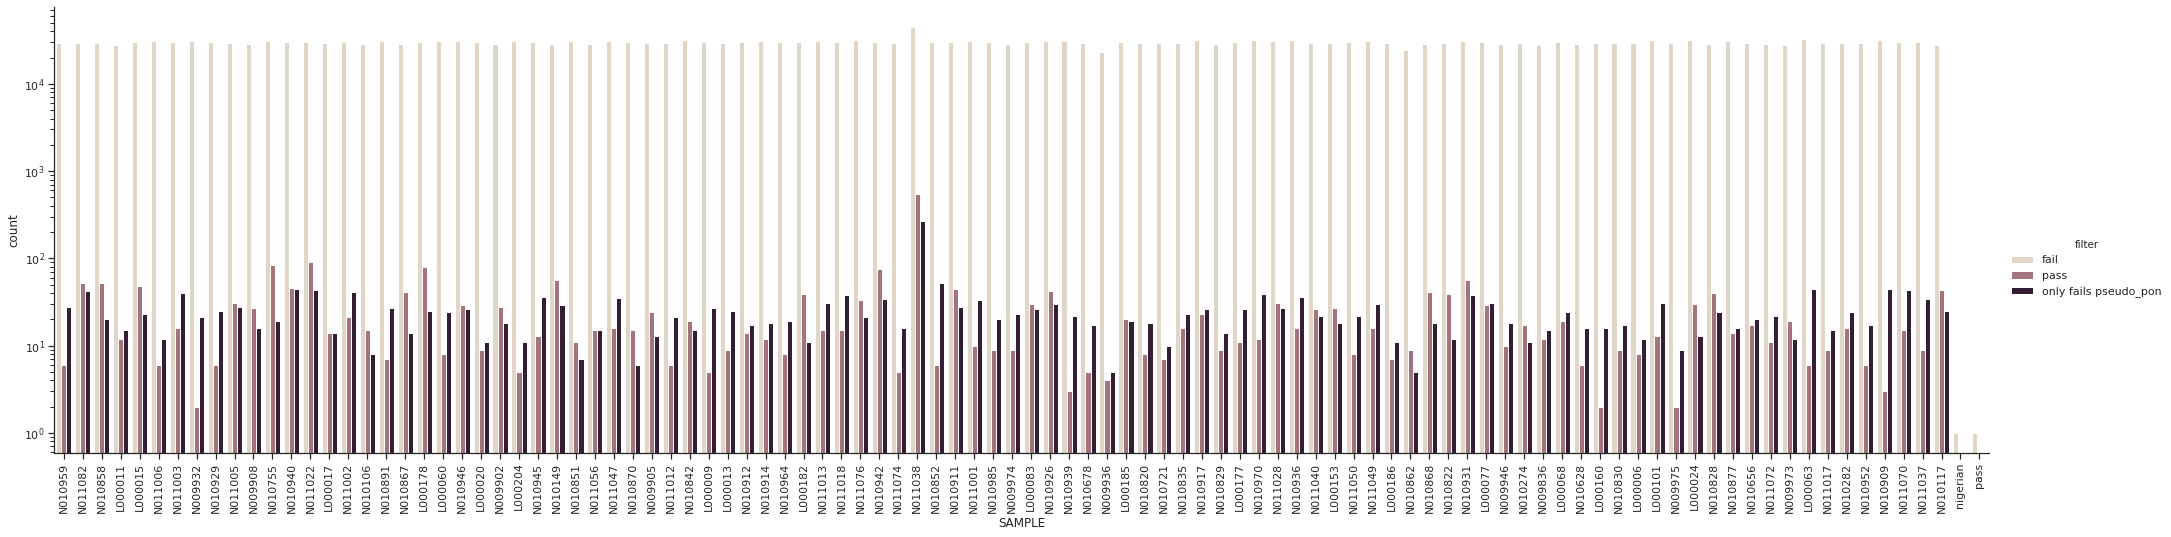

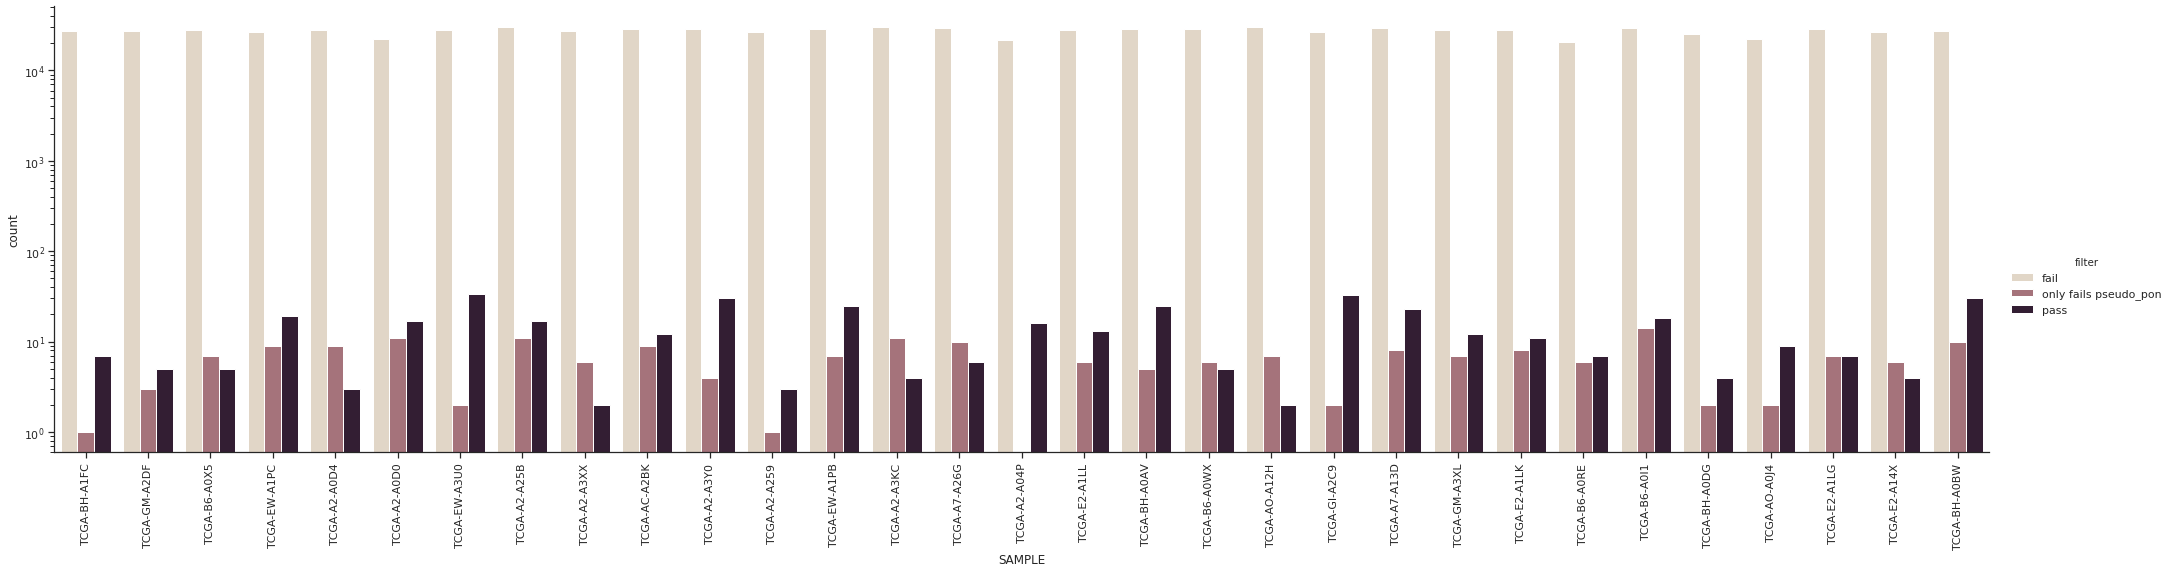

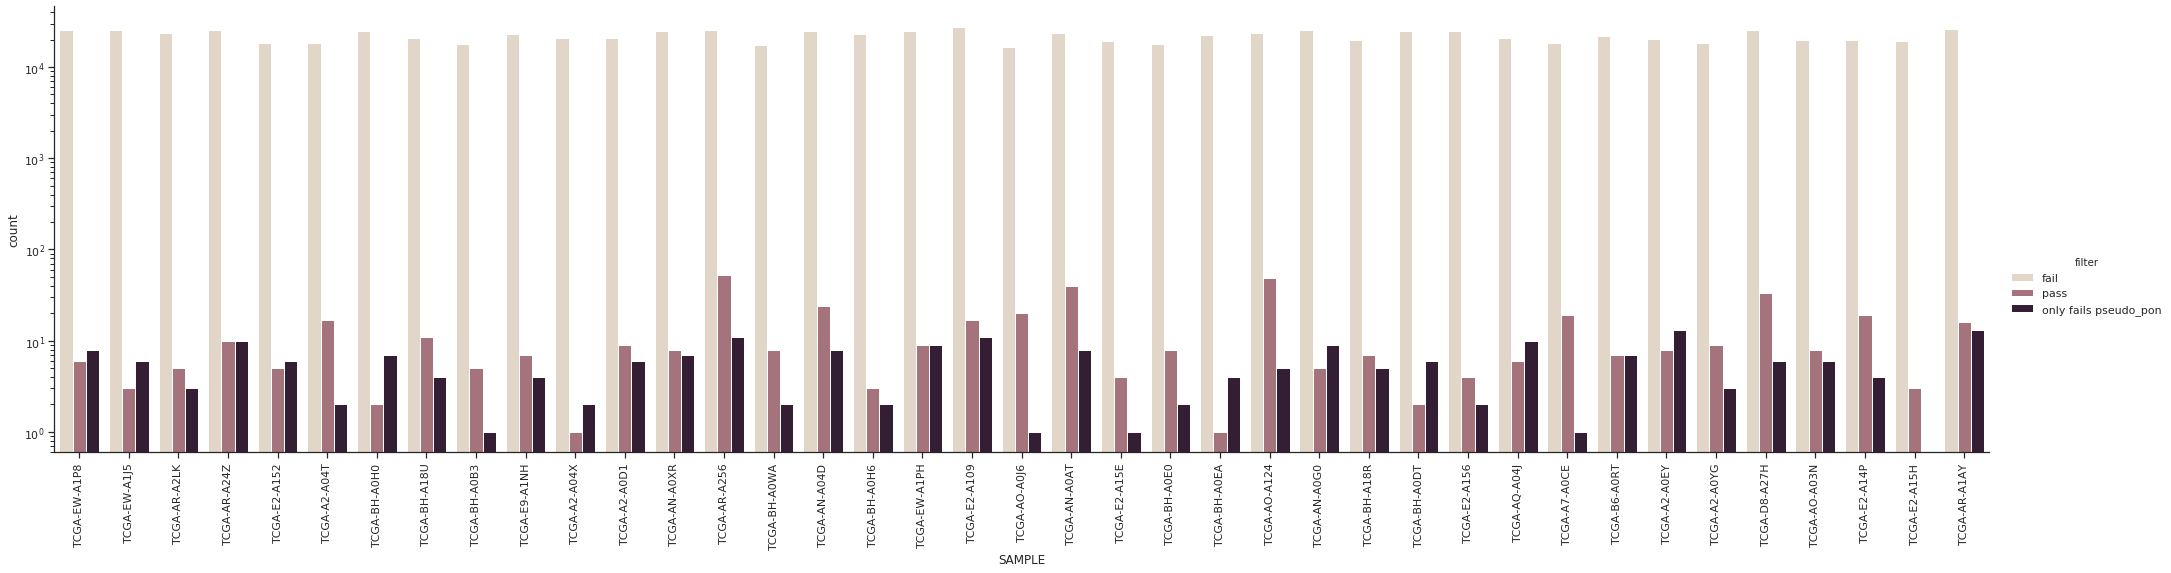

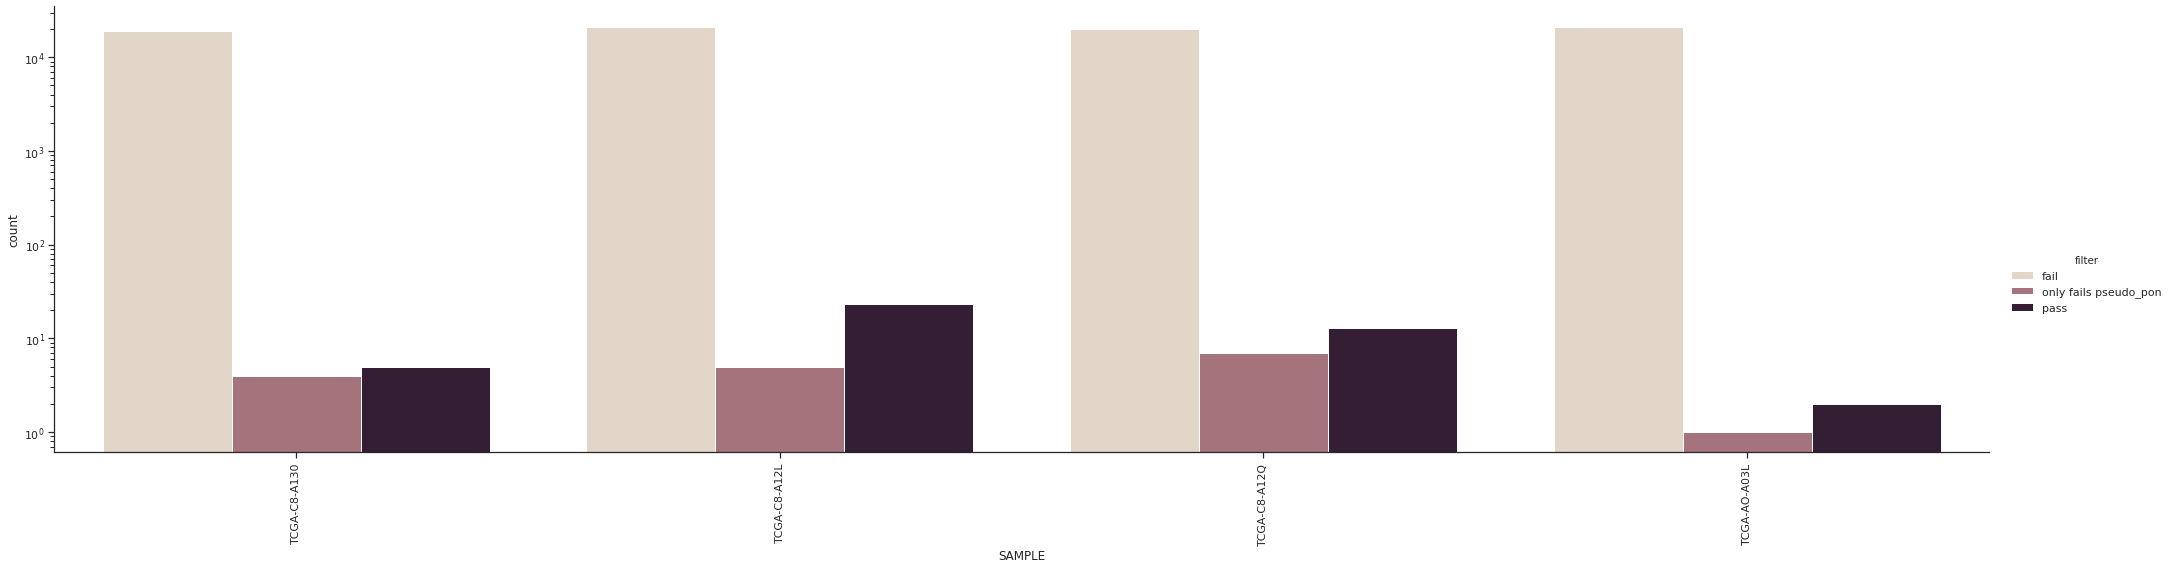

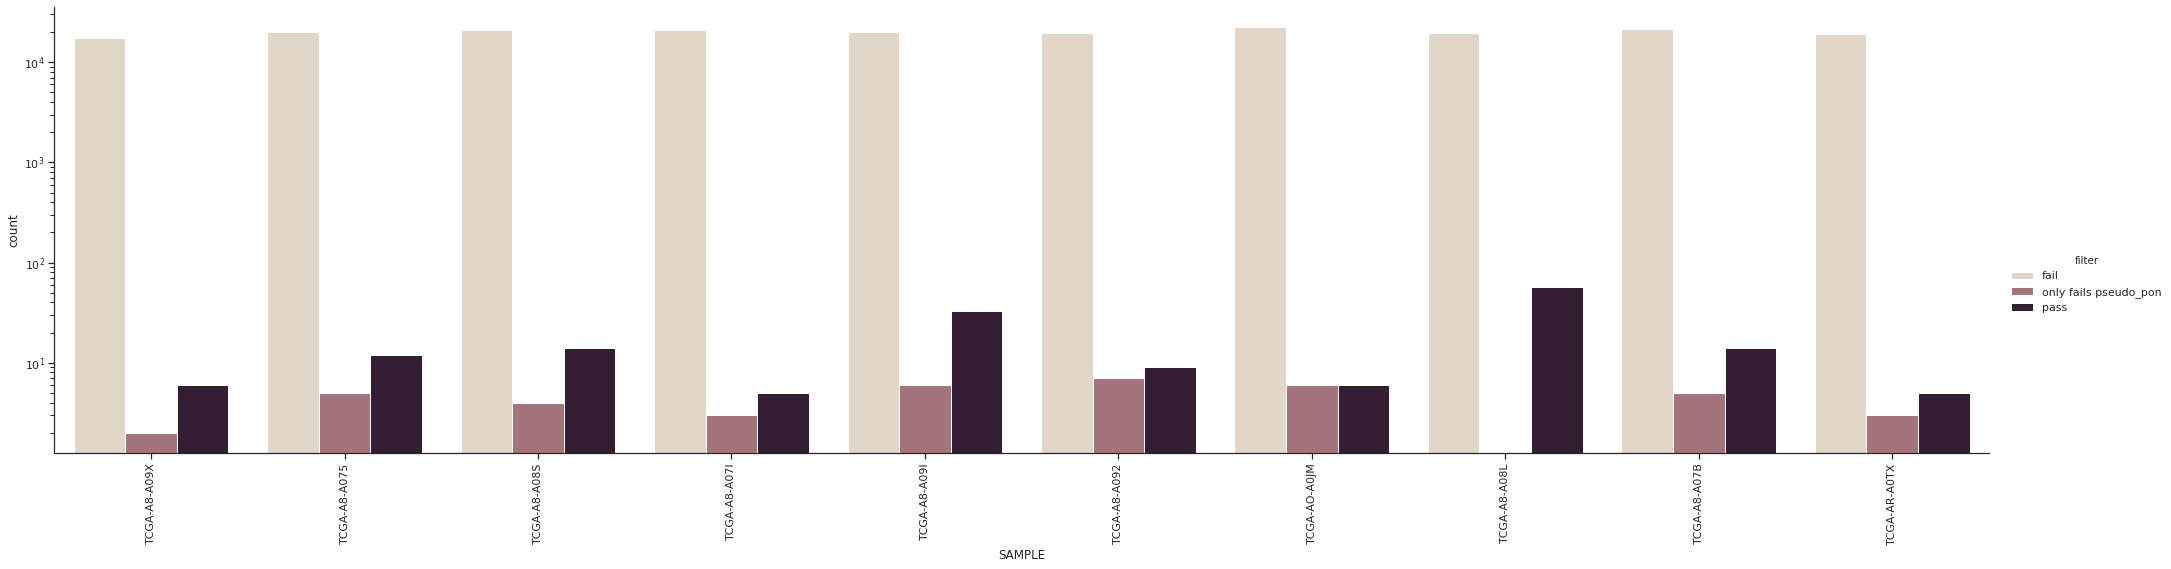

In [30]:
for race in df.race.unique():
    ax = sns.catplot(x="SAMPLE", hue="filter", kind="count", palette="ch:.25", data=df[df.race == race], height=7, aspect=4)
    ax.set_xticklabels(rotation=90)
    plt.yscale('log')

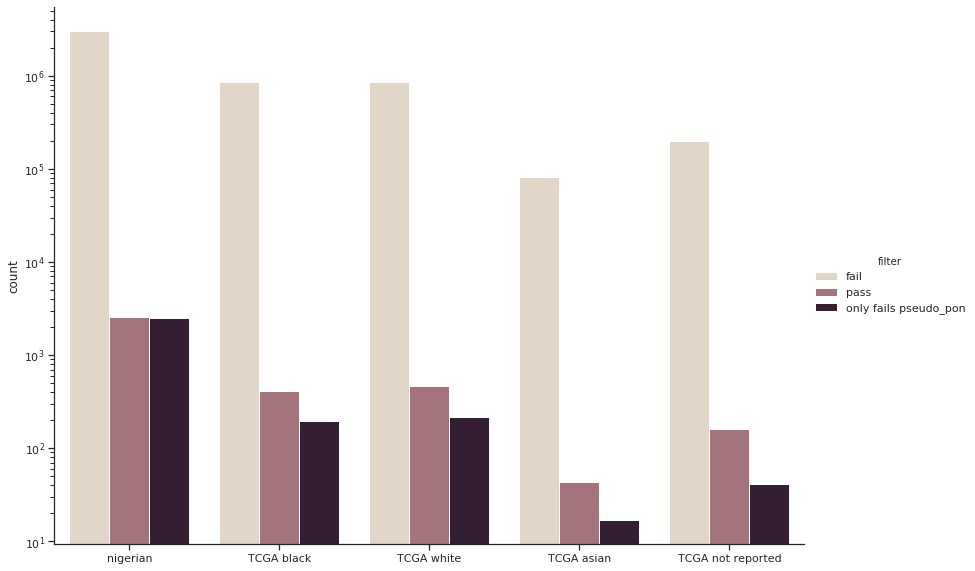

In [25]:
ax = sns.catplot(x="race", hue="filter", kind="count", palette="ch:.25", data=df, height=8.27, aspect=11.7/8.27)
plt.yscale('log')
plt.xlabel('')
plt.savefig('pass_by_race.pdf')

In [13]:
len(df[df.PASS == 'pass']), len(df[df.PASS == 'only fails pseudo_pon']), len(df[df.PASS == 'fail'])

AttributeError: 'DataFrame' object has no attribute 'PASS'

In [ ]:
df[df.FILTER == 'pass']

In [ ]:
df.head()